In [31]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from torch.utils.data import TensorDataset, random_split, DataLoader

In [45]:
class ResNet_Block(torch.nn.Module): # This signifies one block with one skip connection
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResNet_Block, self).__init__()
        self.bn1 = torch.nn.BatchNorm2d(in_channels)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.dropout = torch.nn.Dropout(0.1)

        self.downsample = downsample
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out = self.relu1(out)

        if self.downsample is not None:
            residual = self.downsample(out)

        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out += residual
        return out

class SE_Block(torch.nn.Module):
    def __init__(self, channels, reduction=16):
        super(SE_Block, self).__init__()
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(channels, channels//reduction, bias = False),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(channels//reduction, channels, bias = False),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        batch, channels, w, h = x.size()
        y = self.avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        return x * y.expand_as(x)


class ResNet(torch.nn.Module):
    def __init__(self, block, layers, use_se_block):
        super(ResNet, self).__init__()
        self.block = block
        # Input = 3 channels, 32 * 32
        self.use_se_block = use_se_block
        self.convolution1 = torch.nn.Sequential(
                                torch.nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
                                torch.nn.BatchNorm2d(64),
                                torch.nn.ReLU(inplace=True)) # 32*32
        self.layer0 = self.add_res_net_block(64, 64, layers[0], first_layer_stride = 1) # 32 * 32
        self.layer1 = self.add_res_net_block(64, 128, layers[1], first_layer_stride = 2)#16 *16
        self.layer2 = self.add_res_net_block(128, 256, layers[2], first_layer_stride = 2)#8*8
        self.dropout = torch.nn.Dropout(0.4)
        # Global average pooling and classifier
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(128,10)
          )

        # Initialize weights
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)


    def add_res_net_block(self, in_channels, out_channels, num_layers, first_layer_stride):
        downsample = None
        if first_layer_stride != 1 or in_channels != out_channels:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride=first_layer_stride, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )
        block_layers = []
        block_layers.append(self.block(in_channels, out_channels, first_layer_stride, downsample))
        for _ in range(num_layers-1):
            block_layers.append(self.block(out_channels, out_channels, 1, None))

            if self.use_se_block:
              block_layers.append(SE_Block(out_channels))

        return torch.nn.Sequential(*block_layers)

    def forward(self, x):
        x = self.convolution1(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [33]:
def get_transformations():
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    return train_transform, test_transform

In [41]:
def train_model(model, train_data_loader, validation_data_loader, label_smoothing = 0, lr = 0.1, weight_decay = 0.0005, momentum=0.9, nesterov=True, epochs=100, use_mixup=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loss = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay, momentum=momentum, nesterov=nesterov)

    def lr_schedule_with_warmup(epoch):
        if epoch < 5:
            return (epoch+1)/5
        return 0.5 * (1 + np.cos(np.pi * (epoch-5)/(epochs-5)))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule_with_warmup)

    train_loss = []
    val_loss = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
      trainloss = 0.0
      valloss = 0.0
      val_correct = 0
      train_correct = 0
      val_total = 0
      train_total = 0
      model.train() # telling python that we are intereseted in updating any trainable parameters in the network

      for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # makes sure we have zeroes out gradients for trainable parameters from the previous iteration
        pred = model(images) # forward pass
        fit = loss(pred, labels)
        fit.backward() # backward
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step() # updates the weight
        trainloss += fit.item()
        _, predicted = torch.max(pred, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
      model.eval()
      for images, labels in validation_data_loader:
        with torch.no_grad():
          images = images.to(device)
          labels = labels.to(device)
          pred = model(images)
          fit = loss(pred, labels)
          valloss += fit.item()
          _, predicted = torch.max(pred, 1)
          val_correct += (predicted == labels).sum().item()
          val_total += labels.size(0)

      trainloss = trainloss/len(train_data_loader)
      valloss = valloss/len(validation_data_loader)
      val_loss.append(valloss)
      train_loss.append(trainloss)

      val_accuracy = 100 * val_correct/val_total
      train_accuracy = 100 * train_correct/train_total
      val_accuracies.append(val_accuracy)
      train_accuracies.append(train_accuracy)

      scheduler.step(valloss)

      print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {trainloss:.2f}, val loss: {valloss:.2f}, Train Accuracy: {train_accuracy:.2f}%, val Accuracy: {val_accuracy:.2f}%')

    return model, train_loss, val_loss, train_accuracies, val_accuracies


In [42]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [38]:
# Build data
train_transform, test_transform = get_transformations()
train = []
train_labels = []
test = []
test_labels = []

for i in [1,2,3,4,5]:
  batch = unpickle(f'./data_batch_{i}')
  train.append(batch[b'data'])
  train_labels.extend(batch[b'labels'])
train = np.vstack(train)
train = train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)

test_batch = unpickle('./test_batch')
test = np.array(test_batch[b'data'])
test = test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_labels = np.array(test_batch[b'labels'])

train_dataset = [(train_transform(image), label) for image, label in zip(train, train_labels)]
test_dataset = [(test_transform(image), label) for image, label in zip(test, test_labels)]

train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers = 4)
validation_data_loader = DataLoader(test_dataset, batch_size = 256, shuffle=False, num_workers=4)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(ResNet_Block, [4,4,3], True).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
           Dropout-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
     ResNet_Block-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [44]:
model, train_loss, val_loss, train_accuracies, val_accuracies = train_model(model, train_data_loader, validation_data_loader,label_smoothing = 0.1, lr = 0.1, weight_decay = 0.001, momentum=0.9, nesterov=True, epochs=50, use_mixup=False)

Epoch: 1/50, Train Loss: 2.06, val loss: 1.91, Train Accuracy: 24.73%, val Accuracy: 33.69%
Epoch: 2/50, Train Loss: 1.74, val loss: 1.69, Train Accuracy: 41.44%, val Accuracy: 45.35%
Epoch: 3/50, Train Loss: 1.50, val loss: 1.54, Train Accuracy: 54.53%, val Accuracy: 53.78%
Epoch: 4/50, Train Loss: 1.36, val loss: 1.25, Train Accuracy: 61.51%, val Accuracy: 65.79%
Epoch: 5/50, Train Loss: 1.26, val loss: 1.17, Train Accuracy: 66.92%, val Accuracy: 70.06%
Epoch: 6/50, Train Loss: 1.18, val loss: 1.19, Train Accuracy: 70.53%, val Accuracy: 69.64%
Epoch: 7/50, Train Loss: 1.12, val loss: 1.07, Train Accuracy: 73.91%, val Accuracy: 75.53%
Epoch: 8/50, Train Loss: 1.06, val loss: 1.11, Train Accuracy: 76.57%, val Accuracy: 73.70%
Epoch: 9/50, Train Loss: 1.02, val loss: 1.09, Train Accuracy: 78.53%, val Accuracy: 74.35%
Epoch: 10/50, Train Loss: 0.98, val loss: 1.09, Train Accuracy: 79.94%, val Accuracy: 75.11%
Epoch: 11/50, Train Loss: 0.95, val loss: 1.06, Train Accuracy: 81.80%, val Acc

KeyboardInterrupt: 

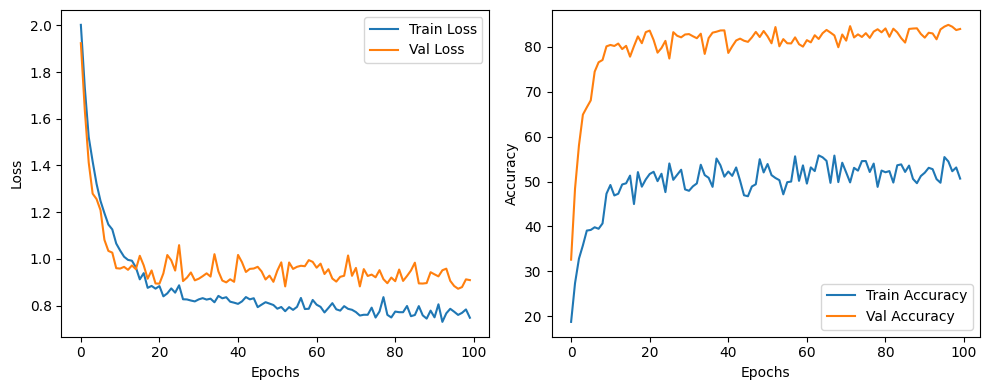

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(train_loss, label="Train Loss")
ax[0].plot(val_loss, label="Val Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(train_accuracies, label="Train Accuracy")
ax[1].plot(val_accuracies, label="Val Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.tight_layout()

In [ ]:
torch.save(model.state_dict(), './ResNet3_4_3.pth')

## Prediction

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
pred_batch = unpickle('cifar_test_nolabel.pkl')
pred_images = pred_batch[b'data'].astype(np.float32) / 255.0
pred_dataset = [test_transform(img) for img in pred_images]
pred_loader = DataLoader(pred_dataset, batch_size=128, shuffle = False)
model.eval()
predictions_made = []
with torch.no_grad():
  for images in pred_loader:
    images = images.to(device)
    pred = model(images)
    _, predicted = torch.max(pred, 1)
    predictions_made.extend(predicted.cpu().numpy())
benchmark = pd.DataFrame({'ID': [i for i in range(len(predictions_made))], 'Labels': predictions_made})
benchmark.to_csv('./benchmark.csv', index=False)